Import dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import os
import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import layers, models

Const

In [2]:
train_path = r'chest_Xray\train'
test_path = r'chest_Xray\test'
val_path = r'chest_Xray/val'

labels = ['NORMAL', 'PNEUMONIA']

IMG_SIZE=200

scale = 1

Import images into array function

In [3]:
def get_training_data(data_dir, size):
    data = list()
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for image in os.listdir(path):
            if(image!=".DS_Store"):
                try:
                    image_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(image_arr, (size, size)) 
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(e)
    return np.array(data, dtype="object")

In [4]:
# x_train, label_train = create_dataset(train_path, IMG_SIZE)
# x_test, label_test = create_dataset(test_path, IMG_SIZE)

In [5]:
test = get_training_data(test_path, IMG_SIZE)
train = get_training_data(train_path, IMG_SIZE)
val = get_training_data(val_path, IMG_SIZE)

Balence datasets

In [6]:
def mix_datasets(array):
    # Pneumonie
    arr_1 = array[np.where(array[:,1] == 1)]
    # Normal
    arr_0 = array[np.where(array[:,1] == 0)]
    l_arr_1 = len(arr_1)
    l_arr_0 = len(arr_0)
    diff = 0

    if l_arr_0 > l_arr_1:
        diff = l_arr_0 - l_arr_1
        arr_0.resize((l_arr_0 - diff, arr_0.shape[1]))
        array = np.concatenate((l_arr_0, arr_1))
    else:
        diff = l_arr_1 - l_arr_0
        arr_1.resize((l_arr_1 - diff, arr_1.shape[1]))
        array = np.concatenate((arr_0, arr_1))
    return array

Scaling datsets

In [7]:
# train_scaled = train
# test_scaled = test
train_scaled = train[np.random.randint(train.shape[0], size=int(len(train)*scale)), :]
test_scaled = test[np.random.randint(test.shape[0], size=int(len(test)*scale)), :]

Preparing the data

In [8]:
def prepare_dataset(dataset):
    X_ = list()
    y_ = list()
    for features, label in dataset:
        X_.append(features)
        y_.append(label)
    X_ = np.array(X_)
    X_ = X_.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_ = np.array(y_)
    return X_, y_ 

In [9]:
x_train, label_train = prepare_dataset(mix_datasets(train))
x_test, label_test = prepare_dataset(mix_datasets(test))
x_val, label_val = prepare_dataset(mix_datasets(val))

In [10]:
# Append train + test + val data in order to scale our datasets
X = np.concatenate((x_train, x_test))
X = np.concatenate((X, x_val))
Y = np.concatenate((label_train, label_test))
Y = np.concatenate((Y, label_val))

In [11]:
# Hold-Out cross validation
# test_size: what proportion of original data is used for test set 
x_train, x_test, label_train, label_test = train_test_split( X, Y, test_size=0.30)

Normalize data

In [12]:
xmax = np.array(x_train).max()
x_train = x_train / xmax
xmax = np.array(x_test).max()
x_test  = x_test  / xmax

Create model

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(120))
# model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))


Init training's Callback

In [14]:
def callbacks():
    callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath='lstmchar256256128test.h5',
                monitor='loss',
                save_best_only=True
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                min_delta=0,
                patience=4,
                mode='auto',
                baseline=None,
            )
        ]
    return callbacks

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

Compile + train model

In [16]:
# y_test = np.array(y_test)
# y_train = np.array(y_train)
y_test = np.array(label_test)
y_train = np.array(label_train)

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

time1 = time.time()
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks())

# Print duration time
duration_time = time.time() - time1
if duration_time < 60 :  
    print("{} s".format(duration_time)) 
else : 
    print("{} min".format(duration_time/60))

Epoch 1/10


C:\Users\TBRUGE\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


70/70 [==============================] - 76s 1s/step - loss: 0.4393 - accuracy: 0.7978 - val_loss: 0.3722 - val_accuracy: 0.8811
Epoch 2/10
70/70 [==============================] - 74s 1s/step - loss: 0.2780 - accuracy: 0.8953 - val_loss: 0.2736 - val_accuracy: 0.8926
Epoch 3/10
70/70 [==============================] - 75s 1s/step - loss: 0.1830 - accuracy: 0.9382 - val_loss: 0.1865 - val_accuracy: 0.9242
Epoch 4/10
70/70 [==============================] - 75s 1s/step - loss: 0.1480 - accuracy: 0.9472 - val_loss: 0.1865 - val_accuracy: 0.9316
Epoch 5/10
70/70 [==============================] - 73s 1s/step - loss: 0.1401 - accuracy: 0.9468 - val_loss: 0.1686 - val_accuracy: 0.9411
Epoch 6/10
70/70 [==============================] - 82s 1s/step - loss: 0.1180 - accuracy: 0.9644 - val_loss: 0.1616 - val_accuracy: 0.9389
Epoch 7/10
70/70 [==============================] - 76s 1s/step - loss: 0.0955 - accuracy: 0.9653 - val_loss: 0.2261 - val_accuracy: 0.9263
Epoch 8/10
70/70 [=============

loss + accuracy graph

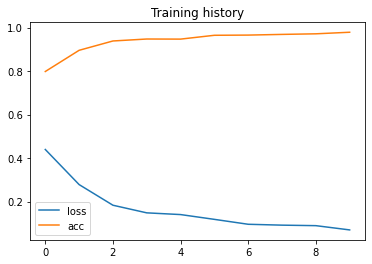

In [18]:
history_loss = history.history["loss"]
history_acc = history.history["accuracy"]

plt.plot(history_loss, label="loss")
plt.plot(history_acc, label="acc")
plt.title("Training history")
plt.legend()

Prediction

In [19]:
pred = model.predict(x_test)

In [20]:
predicted_classes = np.argmax(pred, axis=1)
report = classification_report(predicted_classes, y_test, target_names=labels)
print(report)   

              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.93       433
   PNEUMONIA       0.95      0.93      0.94       517

    accuracy                           0.94       950
   macro avg       0.94      0.94      0.94       950
weighted avg       0.94      0.94      0.94       950



Cunsion matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
cm = confusion_matrix(y_true=label_test, y_pred=predicted_classes)

Confusion matrix, without normalization
[[410  36]
 [ 23 481]]


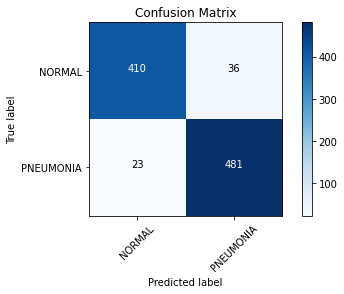

In [23]:
plot_confusion_matrix(cm=cm, classes=labels, title='Confusion Matrix')

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.1496
Test accuracy : 0.9379
